<a href="https://colab.research.google.com/github/princeGedeon/-django-chat-realtime/blob/main/finetuningllm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install ludwig==0.9.1
!pip install ludwig[llm]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 23.5 MB/s eta 0:00:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 19.5 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Mon Dec 11 23:16:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    42W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import getpass
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel

token=""
os.environ["HUGGING_FACE_HUB_TOKEN"] =token
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

In [ ]:
import numpy as np; np.random.seed(123)
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/gdrive')



Mounted at /gdrive


In [ ]:
cd /gdrive/MyDrive/datasets/final_datasets/

/gdrive/MyDrive/datasets/final_datasets


In [ ]:
datafile="last_dataset_rap.xlsx"
df=pd.read_excel(datafile)

In [ ]:
cd /content/

/content


### Analyse

In [ ]:

total_rows = len(df)
split_0_count = int(total_rows * 0.8)
split_1_count = int(total_rows * 0.15)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# Je prends juste les miiles
#df = df.head(n=1000)

In [ ]:
num_self_sufficient = (df['input'] == '').sum()
num_need_context = df.shape[0] - num_self_sufficient


print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_context/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 20492
% of examples that are self-sufficient: 0.0
% of examples that are need additional context: 100.0


In [ ]:
df.head(5)

,Unnamed: 0,input,output,instruction,split
0,0,- La réduction du paquet d'onde est un concept...,"[Couplet 1]\nLa réduction du paquet d'onde, mé...",Transformez du texte en parole de rap,0
1,1,1. Le photoblanchiment est la perte de fluores...,"[Couplet 1]\nLe photoblanchiment, c'est une pe...",Transformez du texte en parole de rap,1
2,2,"1. Le cyanure d'hydrogène, de formule chimique...","[Couplet 1]\nLe cyanure d'hydrogène, si toxiqu...",Transformez du texte en parole de rap,1
3,3,1. Les dimères de pyrimidine sont des lésions ...,"[Couplet 1:]\nDimères de pyrimidine, des lésio...",Transformez du texte en parole de rap,2
4,4,1. Le phytoplancton est un élément du plancton...,"[Couplet 1]\nPhytoplancton, la base de tout éc...",Transformez du texte en parole de rap,1


Average number of tokens in the instruction column: 12
Average number of tokens in the input column: 235
Average number of tokens in the output column: 371



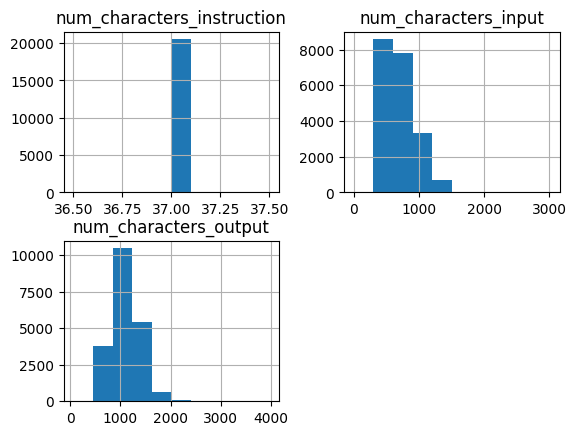

In [ ]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(str(x)))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

## Modélisation

In [ ]:
#meta-llama/Llama-2-7b-hf
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: bofenghuang/vigogne-2-7b-chat

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Voici une consigne décrivant une tâche, accompagnée d'une entrée fournissant le texte à traité.
    Rédigez des paroles de rap en français qui corresspond de manière appropriée la demande.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.2
  max_new_tokens: 1000

adapter:
  type: lora

quantization:
  bits: 8

preprocessing:
  global_max_sequence_length: 1000
  split:
    type: random
    probabilities:
    - 0.80
    - 0.15
    - 0.05

trainer:
  type: finetune
  epochs: 2
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.0004
  learning_rate_scheduler:
    warmup_fraction: 0.03
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

tokenizer_config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of bofenghuang/vigogne-2-7b-chat tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'None': 870 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 872 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 872 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of bofenghuang/vigogne-2-7b-chat tokenizer
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO:ludwig.features.text_feature:Max length of feature 'output': 1418 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 1420 (including start and stop symbols)
INFO:l

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00007.bin:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00007.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00003-of-00007.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00004-of-00007.bin:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

pytorch_model-00005-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00006-of-00007.bin:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

pytorch_model-00007-of-00007.bin:   0%|          | 0.00/1.66G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

INFO:ludwig.models.llm:Done.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of bofenghuang/vigogne-2-7b-chat tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 32788 step(s), approximately 2 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 81970 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:   0%|          | 0/32788 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training:  50%|█████     | 16394/32788 [5:33:50<6:54:08,  1.52s/it, loss=0.06]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 16394, epoch: 0


Evaluation test :   0%|          | 0/513 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 513/513 [26:31<00:00,  3.10s/it]


INFO:ludwig.trainers.trainer:Evaluation took 1h 46m 1.2031s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1851 │       0.1701 │     0.1726 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0567 │       1.0358 │     1.0514 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.9283 │       1.6453 │     1.6783 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15745.1992 │   17974.0117 │ 18068.7402 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31569.4844 │   31608.9492 │ 31605.7227 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │   

Training: 100%|██████████| 32788/32788 [12:53:55<00:00,  1.50s/it, loss=0.0531]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 32788, epoch: 1


Evaluation test :   0%|          | 0/513 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 513/513 [25:44<00:00,  3.01s/it]


INFO:ludwig.trainers.trainer:Evaluation took 1h 42m 54.9846s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.1909 │       0.1667 │     0.1716 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0441 │       0.9997 │     1.0135 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.8483 │       1.9228 │     1.9536 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15535.9590 │   18602.3730 │ 18672.4238 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31577.0723 │   31659.0000 │ 31656.3418 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │  

Training: 100%|██████████| 32788/32788 [14:36:51<00:00,  1.60s/it, loss=0.0531]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ output             │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 16394              │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 1                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.6453009843826294 │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 1.6783009767532349 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

In [ ]:
cd /gdrive/MyDrive/models_rap/

/gdrive/MyDrive/models_rap


In [ ]:


model.save("last_model2")

In [ ]:
cp -r /content/results/api_experiment_run_0/model/ /gdrive/MyDrive/models_rap/model_latest2/

cp: cannot stat '/content/results/api_experiment_run_0/model/': No such file or directory


In [ ]:
model

## Inférence

In [ ]:
test_examples = pd.DataFrame([
      {
            "instruction": "Transforme ce texte portant sur le Machine Learning en parole de rap",
            "input":"""Norme : Une norme est une règle de conduite appliquée dans une société, pouvant être informelle (non écrite, habituelle ou coutumière comme les traditions) ou formelle (écrite et détaillée, comme les lois).

Valeur : Une valeur est un principe reconnu par les individus d'une même société comme bon ou juste, vers lequel on doit idéalement tendre.

Socialisation : La socialisation est un processus d'apprentissage complexe des normes et des valeurs. Elle se déroule en deux phases : la socialisation primaire (de la naissance à la fin de l'adolescence) et la socialisation secondaire (de la fin de l'adolescence à l'âge adulte).

Intériorisation : L'intériorisation est un procédé qui rend un comportement, une valeur ou une norme naturelle pour l'individu.

Groupe de pairs : Un groupe de pairs est un groupement d'individus ayant le même statut ou les mêmes pratiques.

Rôle social : Le rôle social est l'ensemble des comportements attendus d'un individu dans une société en fonction des circonstances.

Identité sociale : L'identité sociale est l'ensemble complexe des caractéristiques sociales d'un individu qui le définissent. """  },


])
predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

In [ ]:
!ludwig upload hf_hub --repo_id princeGedeon/rap_generator_medium --model_path /content/results/api_experiment_run


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 